In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My\ Drive/data/

/content/drive/My Drive/data


In [ ]:
!pip install spectral

In [ ]:
import keras
from keras.layers import Input

from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.7
windowSize = 21

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/data/')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape



((610, 340, 103), (610, 340))

In [ ]:
K = 15 if dataset == 'IP' else 6
X,pca = applyPCA(X,numComponents=K)

X.shape

(610, 340, 6)

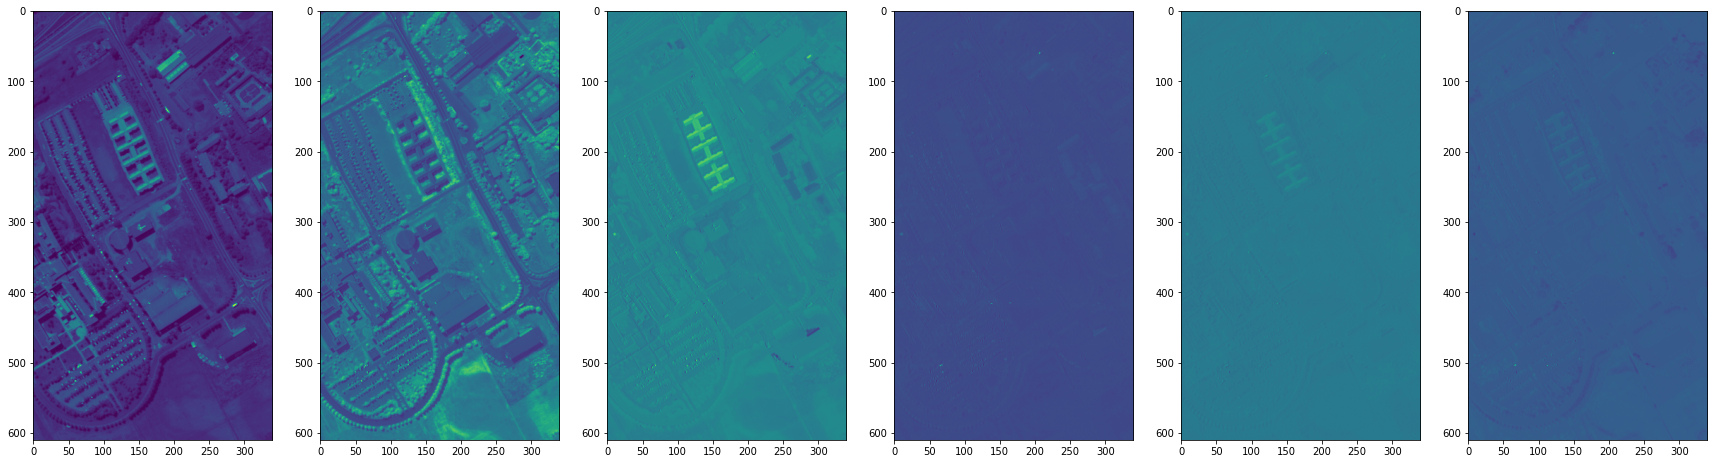

In [ ]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 6, figsize=(30,8))
axes = axes.flatten()
for i in range(6):
    axes[i].imshow(X[:,:,i])

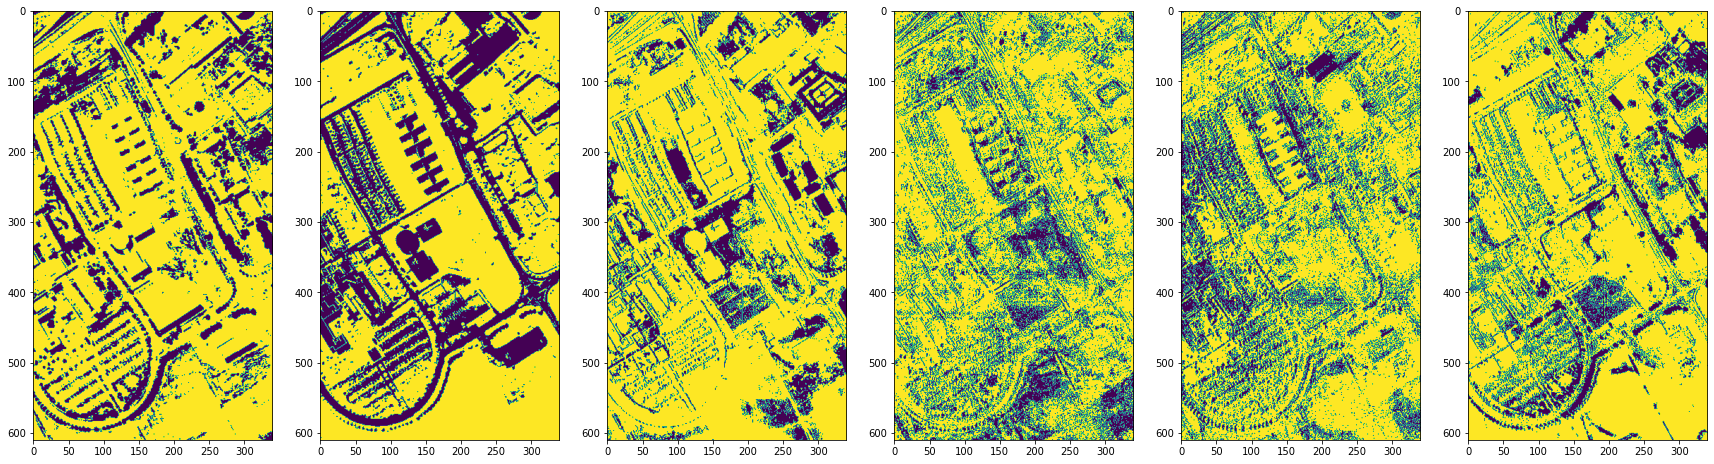

In [ ]:
#Binarization of image
bimage = (255*(X - np.min(X))/np.ptp(X)).astype(int)   
th=np.sum(bimage)//(610*340*K)
bimage= np.where(bimage >= th, bimage, 0)
bimage= np.where(bimage <th, bimage, 1)
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 6, figsize=(30,8))
axes = axes.flatten()
for i in range(6):
    axes[i].imshow(bimage[:,:,i])

In [ ]:
X1=np.array(bimage[:,:,0:3],np.uint8)
X1.shape

(610, 340, 3)

In [ ]:

import cv2
#data X copied to image

#formation of structuring element
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8) 
#morphological filter(erosion) performed on image
erosion = cv2.erode(X1, kernel, iterations=1)
opening = cv2.morphologyEx(X1, cv2.MORPH_OPEN, kernel)
gradient = cv2.morphologyEx(X1, cv2.MORPH_GRADIENT, kernel)
#eroded image and original data concatenated
X = np.concatenate((X, erosion,opening,gradient), axis=2)


#other mophological features that can be performed
#dilation = cv2.dilate(image, kernel, iterations=1)
#opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
#closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
#gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
X.shape

(610, 340, 15)

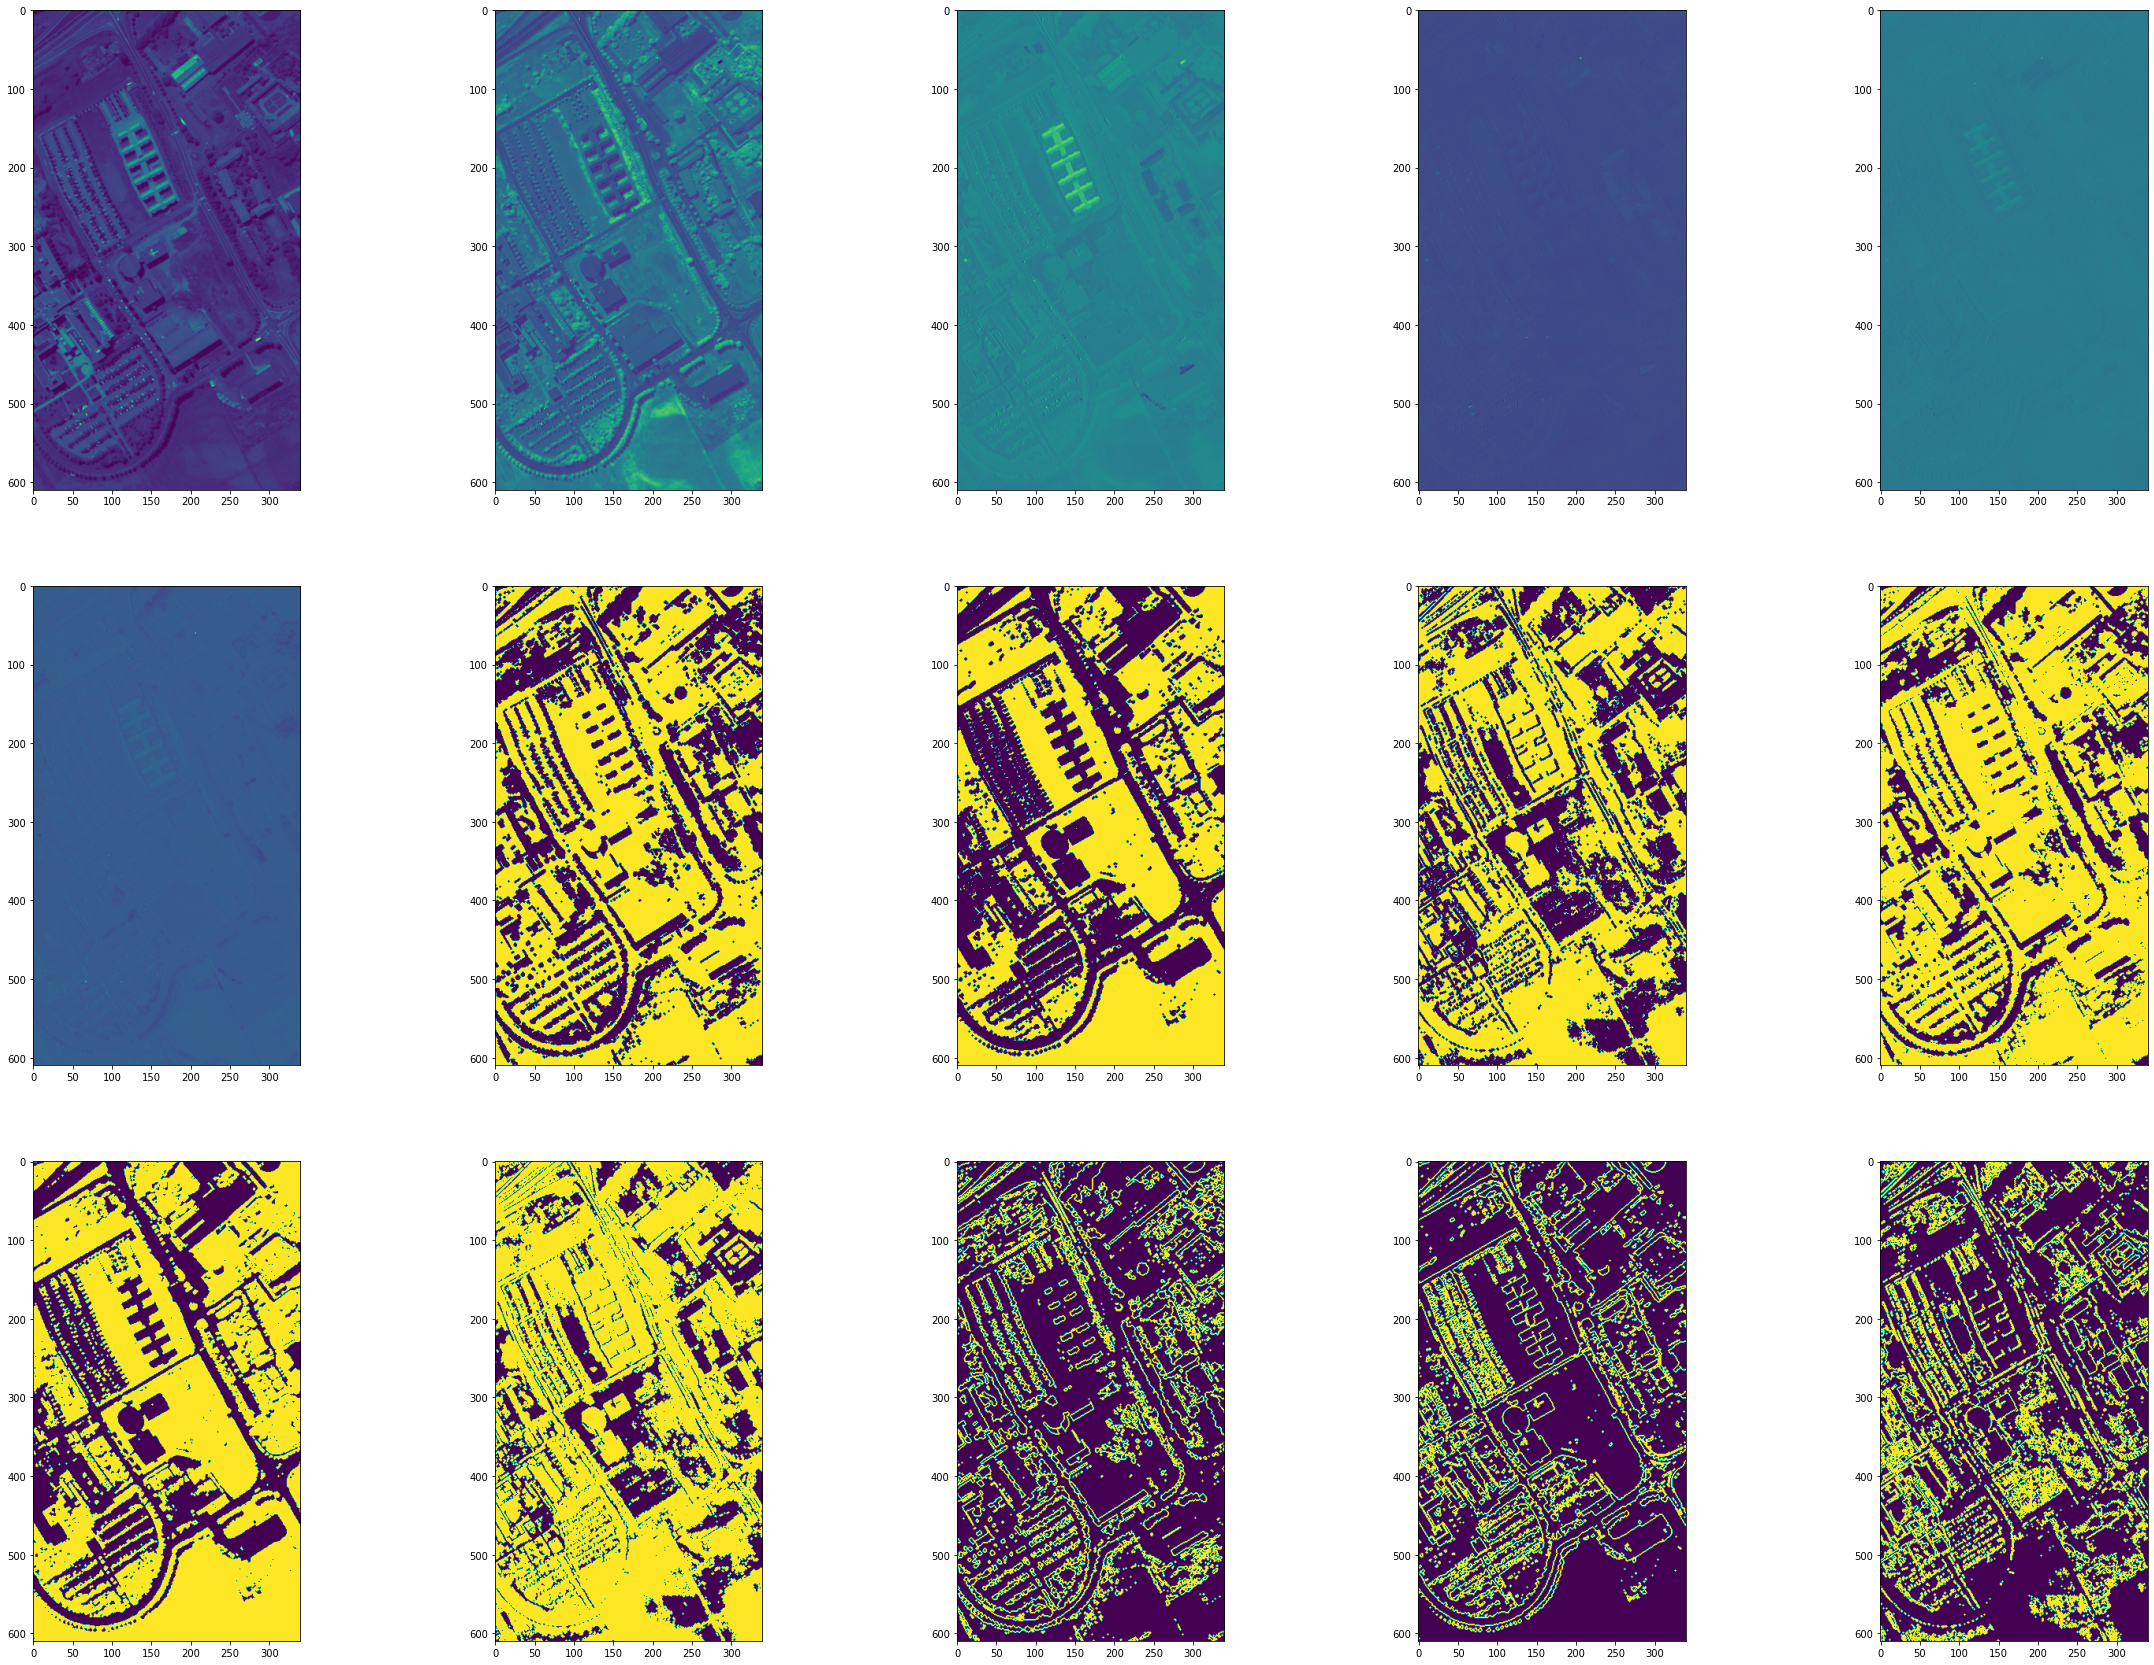

In [ ]:
_, axes = plt.subplots(3, 5, figsize=(40,30))
axes = axes.flatten()
for i in range(15):
    axes[i].imshow(X[:,:,i])

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((42776, 21, 21, 15), (42776,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((12832, 21, 21, 15), (29944, 21, 21, 15), (12832,), (29944,))

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, 15, 1)
Xtrain.shape

(12832, 21, 21, 15, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(12832, 9)

In [ ]:
S = windowSize
L = 15
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3_dilated = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu',dilation_rate=(2,2,1))(conv_layer2)
print(conv_layer3_dilated.shape)
conv3d_shape = conv_layer3_dilated.shape
conv_layer3_dilated = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3_dilated)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu',dilation_rate=2)(conv_layer3_dilated)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 13, 13, 3, 32)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21, 21, 15, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 19, 19, 9, 8)      512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 17, 17, 5, 16)     5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 13, 13, 3, 32)     13856     
_________________________________________________________________
reshape (Reshape)            (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 64)          55360     
_________________________________________________________________
flatten (Flatten)            (None, 5184)             

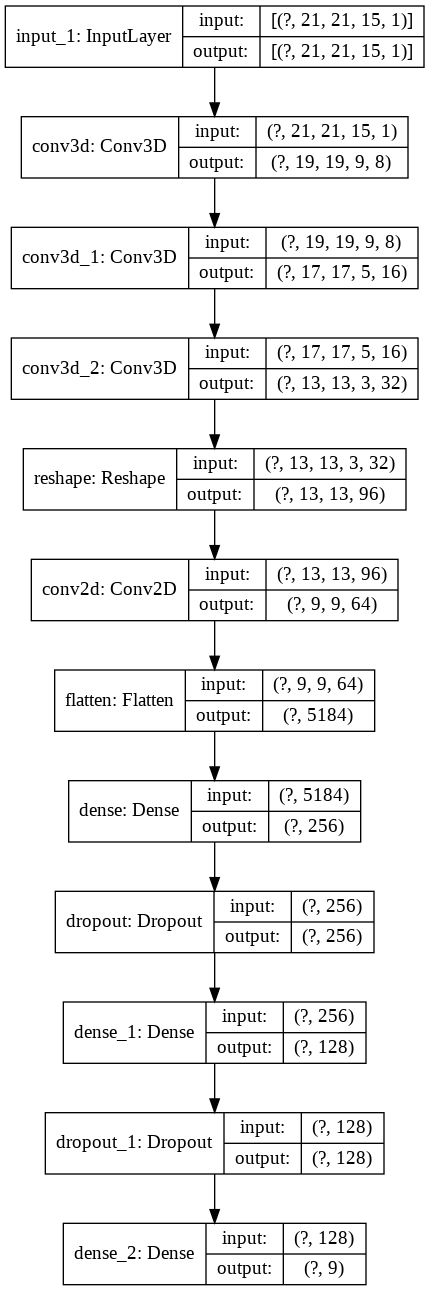

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_morph_PU1.png',show_layer_names='False',show_shapes='True') 
#Plot the model Architecture

In [ ]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "/content/drive/My Drive/data/PU1-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
import time
start=time.time() #Find Start Time
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)
end=time.time() #Find End time

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 0.7898 - accuracy: 0.7247
Epoch 00001: accuracy improved from -inf to 0.72467, saving model to /content/drive/My Drive/data/PU1-model.hdf5
51/51 [==============================] - 2s 39ms/step - loss: 0.7898 - accuracy: 0.7247
Epoch 2/100
50/51 [============================>.] - ETA: 0s - loss: 0.1498 - accuracy: 0.9463
Epoch 00002: accuracy improved from 0.72467 to 0.94631, saving model to /content/drive/My Drive/data/PU1-model.hdf5
51/51 [==============================] - 2s 38ms/step - loss: 0.1496 - accuracy: 0.9463
Epoch 3/100
50/51 [============================>.] - ETA: 0s - loss: 0.0807 - accuracy: 0.9741
Epoch 00003: accuracy improved from 0.94631 to 0.97413, saving model to /content/drive/My Drive/data/PU1-model.hdf5
51/51 [==============================] - 2s 38ms/step - loss: 0.0806 - accuracy: 0.9741
Epoch 4/100
50/51 [============================>.] - ETA: 0s - loss: 0.0522 - accuracy: 0.9851
Epoch 00004

In [ ]:
# load best weights
model.load_weights("/content/drive/My Drive/data/PU1-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, 15, 1)
Xtest.shape

(29944, 21, 21, 15, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(29944, 9)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4642
           1       1.00      1.00      1.00     13055
           2       1.00      1.00      1.00      1469
           3       1.00      1.00      1.00      2145
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00      3520
           6       1.00      1.00      1.00       931
           7       1.00      1.00      1.00      2577
           8       1.00      1.00      1.00       663

    accuracy                           1.00     29944
   macro avg       1.00      1.00      1.00     29944
weighted avg       1.00      1.00      1.00     29944



In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "/content/drive/My Drive/data/PU1_classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))
    x_file.write('\n')
    x_file.write('Time taken for training: {:.2f}s'.format(end-start))

936/936 [==============================] - 3s 3ms/step - loss: 8.5511e-04 - accuracy: 0.9999


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
#Binarization of image
bimage2 = (255*(X - np.min(X))/np.ptp(X)).astype(int)   
th2=np.sum(bimage2)//(610*340*K)
bimage2= np.where(bimage2 >= th2, bimage2, 0)
bimage2= np.where(bimage2 <th2, bimage2, 1)

In [ ]:
X2=np.array(bimage2[:,:,0:3],np.uint8)
X2.shape

(610, 340, 3)

In [ ]:
import cv2
#data X copied to image

#formation of structuring element
kernel2 = np.array([[0,1,0],[1,1,1],[0,1,0]], np.uint8) 
#morphological filter(erosion) performed on image
erosion2 = cv2.erode(X2, kernel2, iterations=1)
opening2 = cv2.morphologyEx(X2, cv2.MORPH_OPEN, kernel2)
gradient2 = cv2.morphologyEx(X2, cv2.MORPH_GRADIENT, kernel2)
#eroded image and original data concatenated
X = np.concatenate((X, erosion2,opening2,gradient2), axis=2)


#other mophological features that can be performed
#dilation = cv2.dilate(image, kernel, iterations=1)
#opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
#closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
#gradient = cv2.morphologyEx(image, cv2.MORPH_GRADIENT, kernel)
X.shape

(610, 340, 15)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

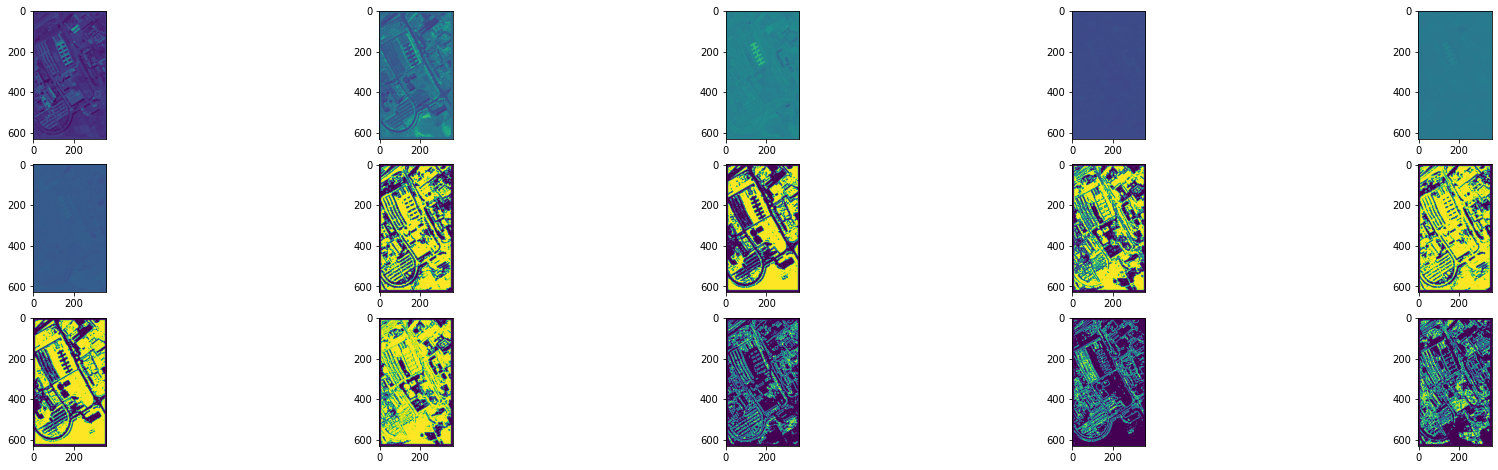

In [ ]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(3, 5, figsize=(30,8))
axes = axes.flatten()
for i in range(15):
    axes[i].imshow(X[:,:,i])

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

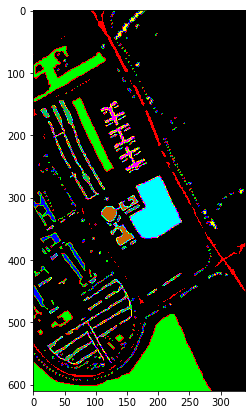

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

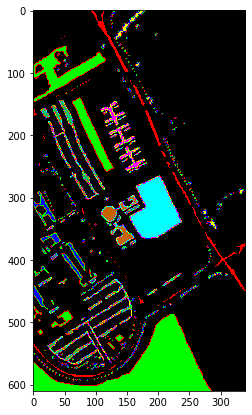

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("/content/drive/My Drive/data/PU1_predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [ ]:
spectral.save_rgb(str(dataset)+"_ground_truth508_PU1.jpg", y, colors=spectral.spy_colors)

In [ ]:
print("Time taken for training: {:.2f}s".format(end-start)) #Calculate Time taken for training

Time taken for training: 186.41s
